In [1]:
# Import necessary packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import Huber
from keras.optimizers import SGD

Using TensorFlow backend.


In [2]:
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame

start = datetime.datetime(2000, 7, 28)
end = datetime.datetime(2019, 9, 2)

df = web.DataReader("ARNA", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-26,54.419998,53.299999,54.160000,54.240002,238300.0,54.240002
2019-08-27,55.230000,52.150002,54.189999,52.660000,310000.0,52.660000
2019-08-28,54.090000,52.430000,52.439999,53.560001,222300.0,53.560001
2019-08-29,54.250000,53.330002,53.939999,53.889999,290900.0,53.889999
2019-08-30,54.090000,52.500000,54.029999,52.889999,336900.0,52.889999


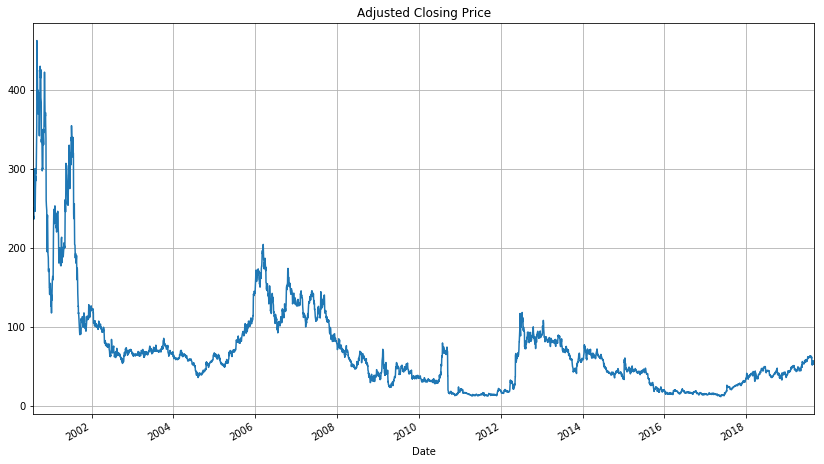

In [3]:
df['Adj Close'].plot(label='ARNA', figsize=(14,8), title='Adjusted Closing Price', grid=True)

In [0]:
window_size = 32 # Allow us to look at 32 days into the past
# Prepare the data so that we have 32 day windows and predict what the next day should be

# Get indices of access for the data
num_samples = len(df) - window_size
indices = np.arange(num_samples).astype(np.int)[:,None] + np.arange(window_size + 1).astype(np.int)

In [5]:
data = df['Adj Close'].values[indices] # Create the 2D matrix of training samples
data

array([[250.        , 237.5       , 238.75      , ..., 390.        ,
        369.375     , 376.25      ],
       [237.5       , 238.75      , 240.        , ..., 369.375     ,
        376.25      , 396.25      ],
       [238.75      , 240.        , 236.25      , ..., 376.25      ,
        396.25      , 396.875     ],
       ...,
       [ 62.06999969,  61.77000046,  61.31999969, ...,  54.24000168,
         52.65999985,  53.56000137],
       [ 61.77000046,  61.31999969,  61.95000076, ...,  52.65999985,
         53.56000137,  53.88999939],
       [ 61.31999969,  61.95000076,  61.81999969, ...,  53.56000137,
         53.88999939,  52.88999939]])

In [0]:
X = data[:,:-1] # Each row represents 32 days in the past
y = data[:,-1] # Each output value represents the 33rd day

In [0]:
# Train and test split
split_fraction = 0.8
ind_split = int(split_fraction * num_samples)

X_train = X[:ind_split]
y_train = y[:ind_split]

X_test = X[ind_split:]
y_test = y[ind_split:]

In [0]:
# Train
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

# Infer
y_pred_train_ridge = ridge_model.predict(X_train)
y_pred_ridge = ridge_model.predict(X_test)

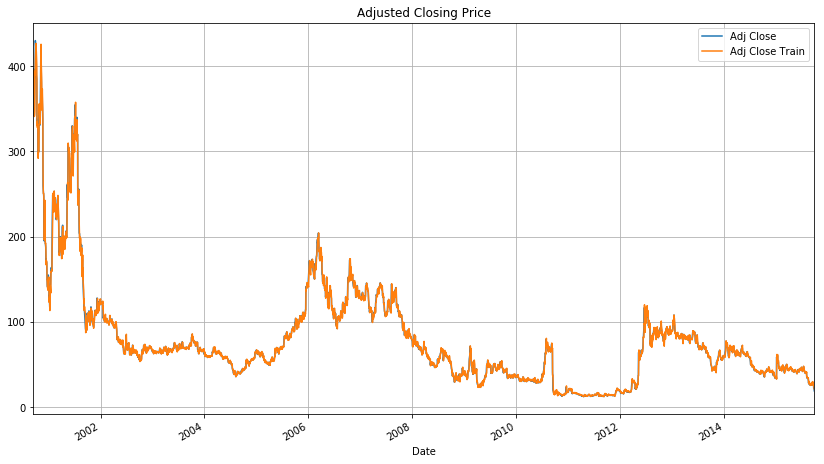

In [9]:
# Plot what it looks like for the training data
df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_ridge['Adj Close Train'] = y_pred_train_ridge[:-window_size]
df_ridge.plot(label='ARNA', figsize=(14,8), title='Adjusted Closing Price', grid=True)

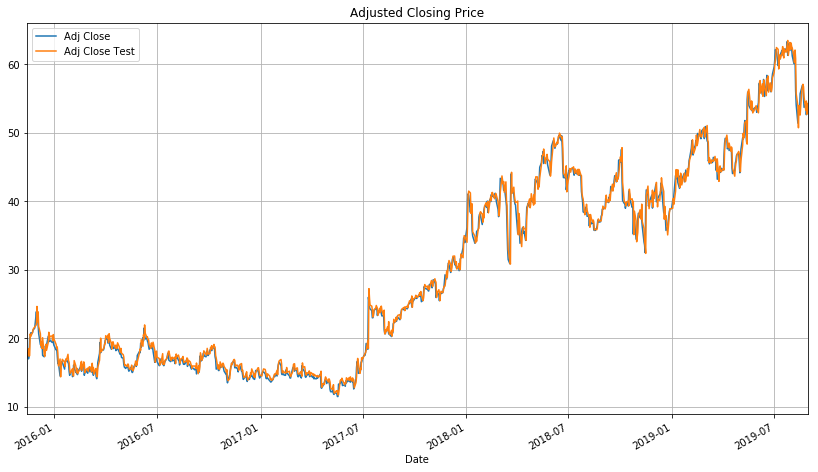

In [10]:
# Same for the test
df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_ridge['Adj Close Test'] = y_pred_ridge
df_ridge.plot(label='ARNA', figsize=(14,8), title='Adjusted Closing Price', grid=True)

In [0]:
# Model #2 - Gradient Boosting Trees
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

# Infer
y_pred_train_gb = gb_model.predict(X_train)
y_pred_gb = gb_model.predict(X_test)

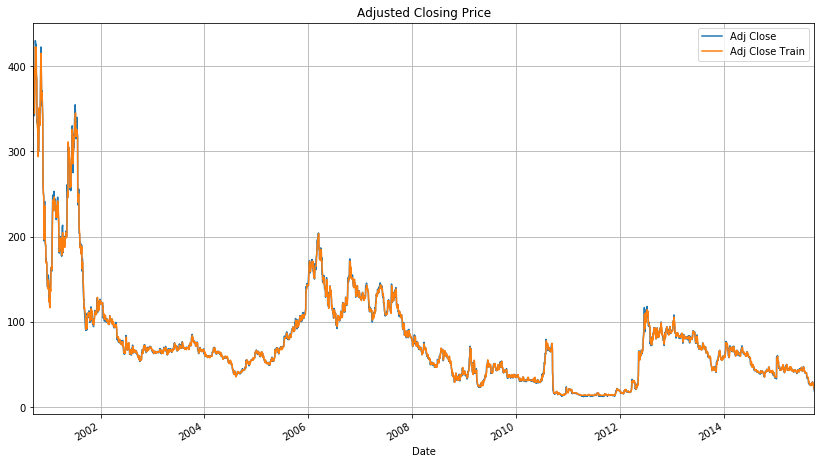

In [12]:
# Plot what it looks like for the training data
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_gb['Adj Close Train'] = y_pred_train_gb[:-window_size]
df_gb.plot(label='ARNA', figsize=(14,8), title='Adjusted Closing Price', grid=True)

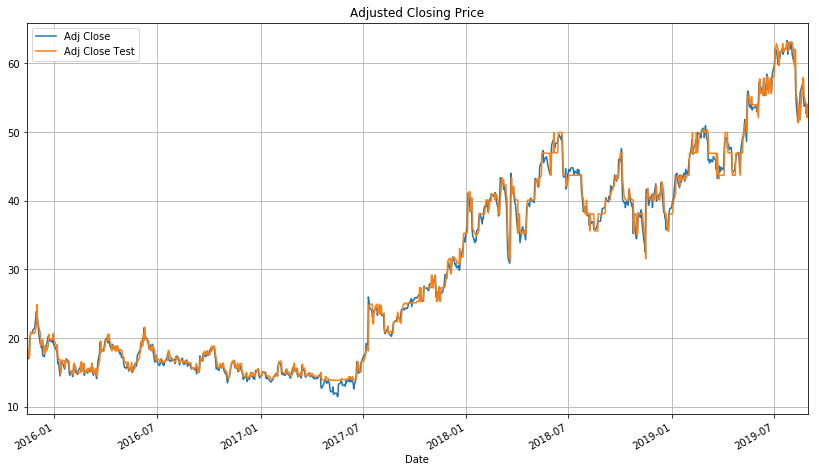

In [13]:
# Same for the test
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_gb['Adj Close Test'] = y_pred_gb
df_gb.plot(label='ARNA', figsize=(14,8), title='Adjusted Closing Price', grid=True)

In [14]:
# Model #3 - Using RNNs
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])

keras_model.summary()

W0902 14:49:31.222582 140214233732992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0902 14:49:31.264373 140214233732992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0902 14:49:31.274428 140214233732992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 32, 128)           768       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 128)           82048     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32, 128)           131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [15]:
# First figure out the right learning rate
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = SGD(lr=1e-8, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])

# Scale the data due to LSTM units
scaler = MinMaxScaler(feature_range=(-1, 1))
data_transform = scaler.fit_transform(df['Adj Close'].values[:,None])
data_transform = data_transform[indices]

X2 = data_transform[:,:-1]
y2 = data_transform[:,-1]

X_train_reshape = X2[:ind_split]
y_train_reshape = y2[:ind_split]

X_test_reshape = X2[ind_split:]
y_test_reshape = y2[ind_split:]

W0902 14:49:37.860110 140214233732992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [16]:
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, callbacks=[lr_schedule], validation_data=(X_test_reshape, y_test_reshape))

W0902 14:49:40.246551 140214233732992 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0902 14:49:41.703812 140214233732992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0902 14:49:41.773437 140214233732992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1020: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 3816 samples, validate on 955 samples
Epoch 1/250
3816/3816 [==============================] - 11s 3ms/step - loss: 0.2698 - mean_absolute_error: 0.7081 - val_loss: 0.4024 - val_mean_absolute_error: 0.8949
Epoch 2/250
3816/3816 [==============================] - 2s 613us/step - loss: 0.2698 - mean_absolute_error: 0.7081 - val_loss: 0.4024 - val_mean_absolute_error: 0.8949
Epoch 3/250
3816/3816 [==============================] - 2s 621us/step - loss: 0.2698 - mean_absolute_error: 0.7081 - val_loss: 0.4024 - val_mean_absolute_error: 0.8948
Epoch 4/250
3816/3816 [==============================] - 2s 639us/step - loss: 0.2698 - mean_absolute_error: 0.7081 - val_loss: 0.4024 - val_mean_absolute_error: 0.8948
Epoch 5/250
3816/3816 [==============================] - 3s 679us/step - loss: 0.2698 - mean_absolute_error: 0.7081 - val_loss: 0.4023 - val_mean_absolute_error: 0.8948
Epoch 6/250
3816/3816 [==============================] - 3s 664us/step - loss: 0.2698 - mean_absolute_error: 

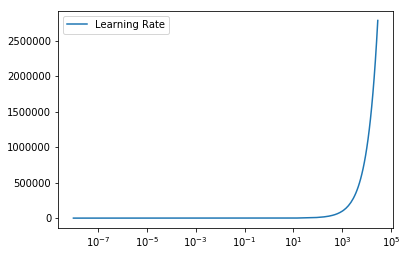

In [17]:
plt.semilogx(history.history['lr'], history.history['val_loss'])
plt.legend(['Learning Rate', 'Validation Loss'])

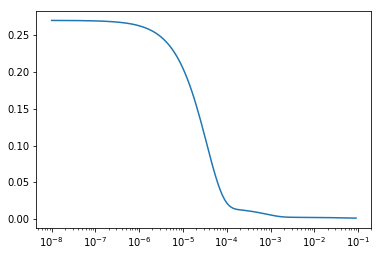

In [18]:
plt.semilogx(history.history['lr'][:140], history.history['loss'][:140])

In [19]:
# Observing the above graph, 0.1 seems to be the best learning rate
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])

optimizer = SGD(lr=0.1, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, validation_data=(X_test_reshape, y_test_reshape))

Train on 3816 samples, validate on 955 samples
Epoch 1/250
3816/3816 [==============================] - 4s 1ms/step - loss: 0.0838 - mean_absolute_error: 0.3286 - val_loss: 0.0016 - val_mean_absolute_error: 0.0513
Epoch 2/250
3816/3816 [==============================] - 3s 719us/step - loss: 0.0183 - mean_absolute_error: 0.1295 - val_loss: 0.0054 - val_mean_absolute_error: 0.1025
Epoch 3/250
3816/3816 [==============================] - 3s 699us/step - loss: 0.0049 - mean_absolute_error: 0.0683 - val_loss: 0.0026 - val_mean_absolute_error: 0.0659
Epoch 4/250
3816/3816 [==============================] - 3s 706us/step - loss: 0.0028 - mean_absolute_error: 0.0459 - val_loss: 6.8405e-04 - val_mean_absolute_error: 0.0320
Epoch 5/250
3816/3816 [==============================] - 3s 714us/step - loss: 0.0023 - mean_absolute_error: 0.0390 - val_loss: 3.1700e-04 - val_mean_absolute_error: 0.0218
Epoch 6/250
3816/3816 [==============================] - 3s 710us/step - loss: 0.0022 - mean_absolute_

In [0]:
y_pred_train_keras = scaler.inverse_transform(keras_model.predict(X_train_reshape, batch_size=256))
y_pred_keras = scaler.inverse_transform(keras_model.predict(X_test_reshape, batch_size=256))

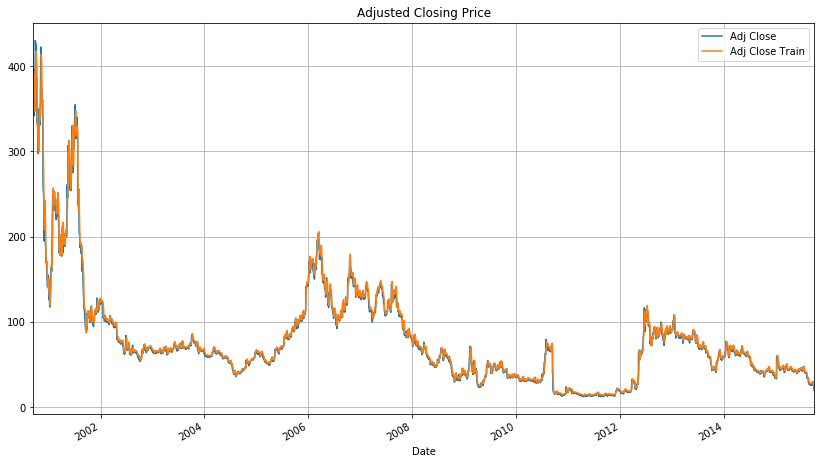

In [22]:
# Plot what it looks like for the training data
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_keras['Adj Close Train'] = y_pred_train_keras[:-window_size]
df_keras.plot(label='ARNA', figsize=(14,8), title='Adjusted Closing Price', grid=True)

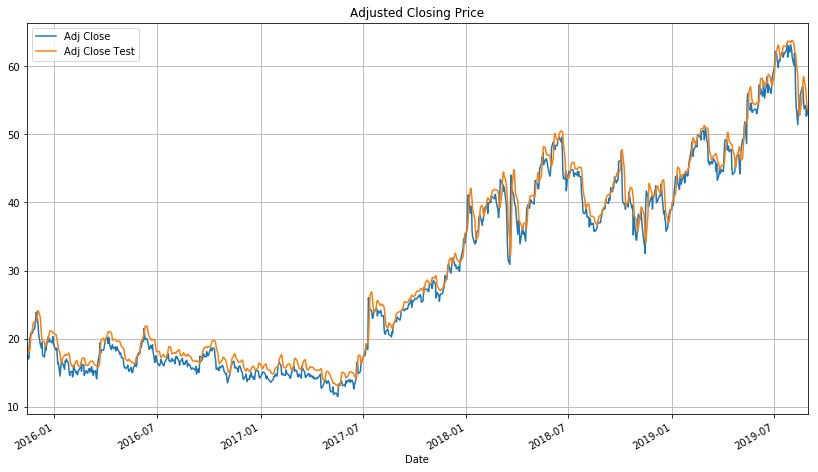

In [23]:
# Same for the test
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_keras['Adj Close Test'] = y_pred_keras
df_keras.plot(label='ARNA', figsize=(14,8), title='Adjusted Closing Price', grid=True)

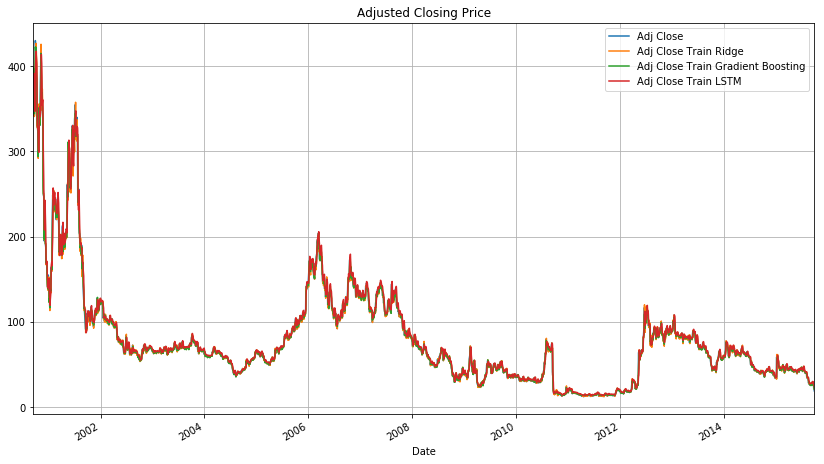

In [24]:
df_train = df.copy()
df_train.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_train = df_train.iloc[window_size:ind_split] # Past 32 days we don't know yet

# Add in all of our methods
df_train['Adj Close Train Ridge'] = y_pred_train_ridge[:-window_size]
df_train['Adj Close Train Gradient Boosting'] = y_pred_train_gb[:-window_size]
df_train['Adj Close Train LSTM'] = y_pred_train_keras[:-window_size]

# Plot the data now
df_train.plot(label='ARNA', figsize=(14,8), title='Adjusted Closing Price', grid=True)

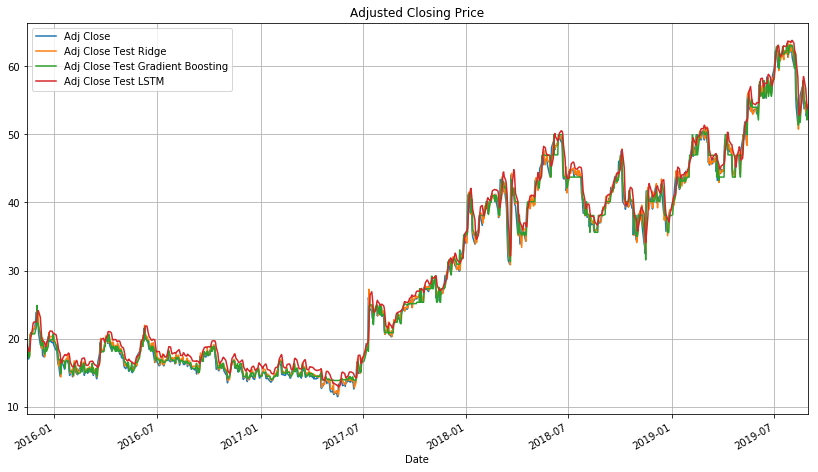

In [25]:
df_test = df.copy()
df_test.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_test = df_test.iloc[ind_split+window_size:] # Past 32 days we don't know yet

# Add in all of our methods
df_test['Adj Close Test Ridge'] = y_pred_ridge
df_test['Adj Close Test Gradient Boosting'] = y_pred_gb
df_test['Adj Close Test LSTM'] = y_pred_keras

# Plot the data now
df_test.plot(label='ARNA', figsize=(14,8), title='Adjusted Closing Price', grid=True)